In [149]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

# Load data SQL

In [150]:
def load_sql(query: str) -> pd.DataFrame:
    load_dotenv()
    db_user= os.getenv("DB_USER")
    db_password= os.getenv("DB_PASSWORD")
    db_host= os.getenv("DB_HOST")
    db_name= os.getenv("DB_NAME")
    engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}/{db_name}')
    with engine.connect() as conn:
        df = pd.read_sql_query(text(query), conn)
        return df

pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = load_sql("SELECT * FROM raw.pharmacy_sales;")
df = df.sort_values(by=["distributor", "product_name", "year", "city", "month"])
df.head()

,distributor,customer_name,city,country,latitude,longitude,channel,sub_channel,product_name,product_class,quantity,price,sales,month,year,sales_rep_name,manager,sales_team
207687,Bashirian-Kassulke,Rogahn-Klein Pharma Plc,Leinfelden-Echterdingen,Germany,48.69,9.14,Pharmacy,Institution,Abatatriptan,Antibiotics,2.00,742.00,1484.00,February,2020,Stella Given,Alisha Cordwell,Charlie
187350,Bashirian-Kassulke,Runolfsson-Halvorson Pharm,Rheinberg,Germany,51.55,6.60,Pharmacy,Retail,Abranatal Lysoprosate,Antiseptics,15826.00,681.00,10777506.00,August,2019,Mary Gerrard,Britanny Bold,Delta
254078,Bashirian-Kassulke,Hane Ltd Pharmaceutical Ltd,Aichach,Germany,48.45,11.13,Hospital,Private,Abranatal Lysoprosate,Antiseptics,432.00,681.00,294192.00,December,2020,Anne Wu,Britanny Bold,Delta
175417,Bashirian-Kassulke,Doyle-Tillman Pharmaceutical Limited,Zirndorf,Germany,49.45,10.95,Pharmacy,Institution,Acantaine,Antibiotics,50.00,66.00,3300.00,June,2019,Thompson Crawford,James Goodwill,Alfa
246485,Bashirian-Kassulke,"Langworth, Olson and Satterfield Pharmacy",Meschede,Germany,51.35,8.28,Hospital,Government,Aciprex,Antipiretics,150.00,421.00,63150.00,November,2020,Thompson Crawford,James Goodwill,Alfa


In [151]:
df[['quantity', 'sales']].head(10)

,quantity,sales
207687,2.00,1484.00
187350,15826.00,10777506.00
254078,432.00,294192.00
175417,50.00,3300.00
246485,150.00,63150.00
232401,20.00,8420.00
53000,2500.00,1695000.00
254079,320.00,216960.00
158400,60.00,1440.00
188559,2000.00,48000.00


# Feature Engineering

In [152]:
features = (df.groupby(["distributor",
                    "channel",
                    "sub_channel",
                    "city",
                    "product_name",
                    "product_class",
                    "sales_team",
                    "year",
                    "month",]).agg(
                total_quantity=("quantity", "sum"),
                total_sales=("sales", "sum"),
                avg_price=("price", "mean"),
                    ).reset_index())

sort_columns = ["distributor", "channel", "sub_channel", "city", 
    "product_name", "product_class", "sales_team", 
    "year", "month"]
features = features.sort_values(by=sort_columns)

In [153]:
grp_cols = [
    "distributor" # Concerned columns to identify what makes features works
]

# Preprocessing total sales
sales_upper_bound = features["total_sales"].quantile(0.90) # Quantile concerned to limit outliers
features["total_sales_clean"] = features["total_sales"].clip(lower=0, upper=sales_upper_bound)

# time series not included
grp = features.groupby(grp_cols)

# add rolling features
features["rolling_avg_sales_3m"] = grp["total_sales_clean"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
# Count percentage growth
features["sales_growth_pct"] = grp["total_sales_clean"].transform(
    lambda x: x.pct_change() * 100
)

In [154]:
# Count IQR
Q1 = features["sales_growth_pct"].quantile(0.25)
Q3 = features["sales_growth_pct"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# -----------------------------------------------------------------------------------------------

growth_upper = features["sales_growth_pct"].quantile(0.90) # Quantile concerned to limit outliers

# Apply clipping
features["sales_growth_pct_clipped"] = features["sales_growth_pct"].clip(
    lower=-100,
    upper=growth_upper
)

In [155]:
# Clean Nan and Inf values
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)
features.head(10)

,distributor,channel,sub_channel,city,product_name,product_class,sales_team,year,month,total_quantity,total_sales,avg_price,total_sales_clean,rolling_avg_sales_3m,sales_growth_pct,sales_growth_pct_clipped
0,Bashirian-Kassulke,Hospital,Government,Altenburg,Symbitrim,Analgesics,Bravo,2019,August,29400.00,15758400.00,536.00,76800.00,76800.00,0.00,0.00
1,Bashirian-Kassulke,Hospital,Government,Bad Salzuflen,Adrecetam Barazoxane,Antimalarial,Bravo,2020,December,16.00,384.00,24.00,384.00,38592.00,-99.50,-99.50
2,Bashirian-Kassulke,Hospital,Government,Bad Tölz,Albuterenone,Antimalarial,Bravo,2019,November,2000.00,164000.00,82.00,76800.00,51328.00,19900.00,1884.19
3,Bashirian-Kassulke,Hospital,Government,Bergkamen,Choriogestrel,Antiseptics,Bravo,2020,September,20.00,6940.00,347.00,6940.00,28041.33,-90.96,-90.96
4,Bashirian-Kassulke,Hospital,Government,Böblingen,Feruprazole,Mood Stabilizers,Charlie,2020,December,565.00,64975.00,115.00,64975.00,49571.67,836.24,836.24
5,Bashirian-Kassulke,Hospital,Government,Crailsheim,Symbitrim,Analgesics,Bravo,2019,August,14700.00,7879200.00,536.00,76800.00,49571.67,18.20,18.20
6,Bashirian-Kassulke,Hospital,Government,Dachau,Ketamara Evogel,Antipiretics,Bravo,2020,December,25.00,17600.00,704.00,17600.00,53125.00,-77.08,-77.08
7,Bashirian-Kassulke,Hospital,Government,Derne,Atrabicin Alkerotec,Antiseptics,Alfa,2019,November,100.00,24900.00,249.00,24900.00,39766.67,41.48,41.48
8,Bashirian-Kassulke,Hospital,Government,Dreieich,Effidomide Evofribrate,Antiseptics,Alfa,2019,February,1440.00,881280.00,612.00,76800.00,39766.67,208.43,208.43
9,Bashirian-Kassulke,Hospital,Government,Elmshorn,Lovephilus,Analgesics,Charlie,2019,October,700.00,407400.00,582.00,76800.00,59500.00,0.00,0.00


In [156]:
# Statistics descriptions
features[['total_sales_clean', 'rolling_avg_sales_3m', 'avg_price', 'sales_growth_pct', 'sales_growth_pct_clipped']].describe()

,total_sales_clean,rolling_avg_sales_3m,avg_price,sales_growth_pct,sales_growth_pct_clipped
count,253642.00,253642.00,253642.00,253642.00,253642.00
mean,17777.58,17777.12,412.24,886.44,316.33
std,24598.72,15405.55,224.97,5500.42,634.41
min,0.00,26.67,22.00,-100.00,-100.00
25%,1715.00,4883.33,195.00,-79.17,-79.17
50%,5850.00,12740.00,430.00,0.00,0.00
75%,21660.00,28032.50,605.00,339.86,380.00
max,76800.00,76800.00,794.00,574900.00,1884.19


# Data scaling

In [157]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
features_scaled = scaler.fit_transform(features[["total_sales_clean", "rolling_avg_sales_3m", "sales_growth_pct_clipped"]])

In [158]:
pd.DataFrame(features_scaled, columns=["total_sales_clean_scaled", "rolling_avg_sales_3m_scaled", "sales_growth_pct_clipped_scaled"]).describe()

,total_sales_clean_scaled,rolling_avg_sales_3m_scaled,sales_growth_pct_clipped_scaled
count,253642.00,253642.00,253642.00
mean,0.60,0.22,0.69
std,1.23,0.67,1.38
min,-0.29,-0.55,-0.22
25%,-0.21,-0.34,-0.17
50%,0.00,0.00,0.00
75%,0.79,0.66,0.83
max,3.56,2.77,4.10


# Data visualization

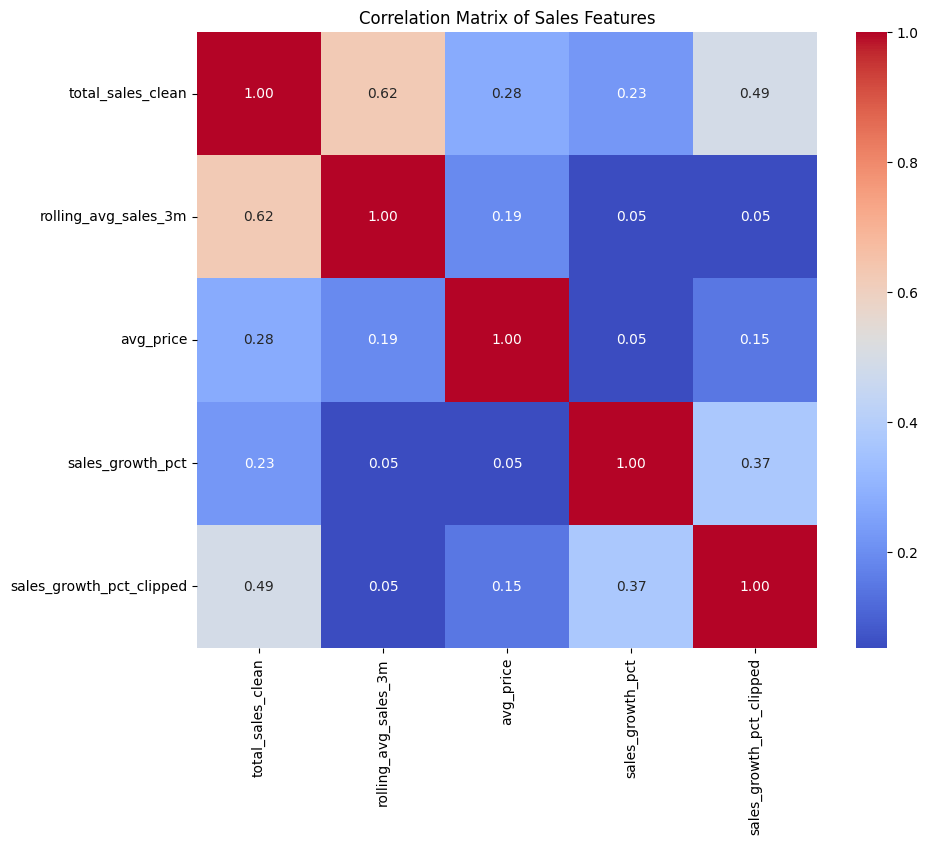

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = features[['total_sales_clean', 'rolling_avg_sales_3m', 'avg_price', 'sales_growth_pct', 'sales_growth_pct_clipped']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Sales Features')
plt.show()

In [160]:
features

,distributor,channel,sub_channel,city,product_name,product_class,sales_team,year,month,total_quantity,total_sales,avg_price,total_sales_clean,rolling_avg_sales_3m,sales_growth_pct,sales_growth_pct_clipped
0,Bashirian-Kassulke,Hospital,Government,Altenburg,Symbitrim,Analgesics,Bravo,2019,August,29400.00,15758400.00,536.00,76800.00,76800.00,0.00,0.00
1,Bashirian-Kassulke,Hospital,Government,Bad Salzuflen,Adrecetam Barazoxane,Antimalarial,Bravo,2020,December,16.00,384.00,24.00,384.00,38592.00,-99.50,-99.50
2,Bashirian-Kassulke,Hospital,Government,Bad Tölz,Albuterenone,Antimalarial,Bravo,2019,November,2000.00,164000.00,82.00,76800.00,51328.00,19900.00,1884.19
3,Bashirian-Kassulke,Hospital,Government,Bergkamen,Choriogestrel,Antiseptics,Bravo,2020,September,20.00,6940.00,347.00,6940.00,28041.33,-90.96,-90.96
4,Bashirian-Kassulke,Hospital,Government,Böblingen,Feruprazole,Mood Stabilizers,Charlie,2020,December,565.00,64975.00,115.00,64975.00,49571.67,836.24,836.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253637,Welch-Langworth,Pharmacy,Retail,Zwickau,Neuropogen Empibax,Analgesics,Delta,2018,September,5.00,3025.00,605.00,3025.00,26942.33,-96.06,-96.06
253638,Welch-Langworth,Pharmacy,Retail,Zwickau,Pulmofine,Antibiotics,Charlie,2018,June,180.00,123840.00,688.00,76800.00,52208.33,2438.84,1884.19
253639,Welch-Langworth,Pharmacy,Retail,Zwickau,Secrelazine Insonamic,Antipiretics,Delta,2018,December,56.00,38864.00,694.00,38864.00,39563.00,-49.40,-49.40
253640,Welch-Langworth,Pharmacy,Retail,Zwickau,Theopril,Antipiretics,Alfa,2018,September,5500.00,4224000.00,768.00,76800.00,64154.67,97.61,97.61
